In [26]:
!pip install -q timm
!pip install Craft-xai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00


In [2]:
# commenter les étapes necessaires

In [3]:
import numpy as np
import cv2
import torch
import torch.nn as nn

from torchvision import transforms
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


In [4]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as T
from PIL import Image
from collections import OrderedDict

## Load DINO backcbone

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the backbone size
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

dino_backbone = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name) # dinov2_vits14

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 116MB/s]


In [6]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_linear4_head.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_linear4_head.pth
100%|██████████| 7.33M/7.33M [00:00<00:00, 33.0MB/s]


In [7]:
# transform for ResNet50
transform = T.Compose([
    T.Resize((518, 518)),  # ou 224x224 selon ton modèle
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# transform for DINOv2
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
])

to_pil=transforms.ToPILImage()

## Retrain dinov2 classification head

**Prepare train-val-test dataset for training**

In [8]:
!curl -L -o /content/cat-vs-rabbit.zip https://www.kaggle.com/api/v1/datasets/download/muniryadi/cat-vs-rabbit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  72.6M      0 --:--:-- --:--:-- --:--:--  203M


In [9]:
!unzip /content/cat-vs-rabbit.zip

Archive:  /content/cat-vs-rabbit.zip
  inflating: test-images/cat/cat.208.jpg  
  inflating: test-images/cat/cat.209.jpg  
  inflating: test-images/cat/cat.210.jpg  
  inflating: test-images/cat/cat.233.jpg  
  inflating: test-images/cat/cat.234.jpg  
  inflating: test-images/cat/cat.235.jpg  
  inflating: test-images/cat/cat.236.jpg  
  inflating: test-images/cat/cat.237.jpg  
  inflating: test-images/cat/cat.238.jpg  
  inflating: test-images/cat/cat.239.jpg  
  inflating: test-images/rabbit/images-2.jpeg  
  inflating: test-images/rabbit/images-3.jpeg  
  inflating: test-images/rabbit/images-4.jpeg  
  inflating: test-images/rabbit/images.jpeg  
  inflating: test-images/rabbit/rabbit_test.jpeg  
  inflating: train-cat-rabbit/cat/cat.1.jpg  
  inflating: train-cat-rabbit/cat/cat.10.jpg  
  inflating: train-cat-rabbit/cat/cat.100.jpg  
  inflating: train-cat-rabbit/cat/cat.101.jpg  
  inflating: train-cat-rabbit/cat/cat.102.jpg  
  inflating: train-cat-rabbit/cat/cat.103.jpg  
  infla

In [11]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# load dataset
root_dir = ''#'/home/ids/nnguyen-24/'
root_train = root_dir+ '/content/train-cat-rabbit/' #'Craft/assets/train-cat-rabbit/'
root_val = root_dir+ '/content/val-cat-rabbit/' #'Craft/assets/val-cat-rabbit/'
root_test = root_dir+ '/content/test-images/' #'Craft/assets/test-cat-rabbit/'
train_data = ImageFolder(root=root_train, transform=transform)
val_data = ImageFolder(root=root_val, transform=transform)
test_data = ImageFolder(root=root_test, transform=transform)



# create Data loaders for batch training
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Check class mappings
print(train_data.class_to_idx)

{'cat': 0, 'rabbit': 1}


**Getting backbone**

In [12]:
# set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the DINOv2 classifier pretrained model from Facebook Research
# classifier_pretrained = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_lc")
dino_backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
print(dino_backbone)

# freeze the model parameters except the classification head
for param in dino_backbone.parameters():
    param.requires_grad = False

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [ ]:
#print(images_preprocessed[:1].shape)
#exemple = dino_backbone.forward_features(images_preprocessed[:1].to(device))
#exemple['x_norm_patchtokens'].shape

**Define a classifier head**

In [13]:
for param in dino_backbone.parameters():
    param.requires_grad = False

def get_patch_tokens(backbone, x):
    """
    Args
      x : (B, 3, H, W)  image tensor
    Returns
      patch_tokens : (B, C, H', W')  feature map 4D
    """
    out = backbone.forward_features(x)            # dict
    tokens = out["x_norm_patchtokens"]            # (B, N, C)
    B, N, C = tokens.shape
    S = int(N ** 0.5)                             # suppose un grid carré
    tokens = tokens.permute(0, 2, 1).reshape(B, C, S, S)
    return tokens


class DINOWrapper(nn.Module):
    """
    Get patchs vectors of images instead of embedding (official final output of DinoV2)
    """
    def __init__(self, backbone) -> None:
      super().__init__()
      self.backbone = dino_backbone
      self.embed_dim = dino_backbone.embed_dim

    def forward(self, x):
        with torch.no_grad():
          features = self.backbone.forward_features(x)["x_norm_patchtokens"]
          B, N, C = features.shape
          S = int(N ** 0.5)                             # suppose un grid carré
          features = features.permute(0, 2, 1).reshape(B, C, S, S)
          features = F.relu(features)
        return features


class Classifier(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super().__init__()
        self.backbone = DINOWrapper(backbone)
        self.head = nn.Linear(self.backbone.embed_dim, num_classes)

    def forward(self, x):
        # with torch.no_grad():
        #     patches = self.backbone(x)   # (B, C, S, S)

        pooled = x.mean(dim=(2, 3))                  # global average, (B, C)
        logits = self.head(pooled)                         # (B, num_classes)
        return logits



In [14]:
# Convert dataloader to features in using DinoWrapper
dino_model = DINOWrapper(dino_backbone)
features_train = []
for image, label in train_loader:
    image = image.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)
    feature = dino_model(image)
    print(feature.shape)
    features_train.append((feature, label))


torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size

## Training

In [15]:
import torch
from collections import OrderedDict

# ------------------------------ 0. Hyper‐paramètres
from torch import optim
lr = 0.01
criteron = nn.CrossEntropyLoss()
model = Classifier(dino_backbone, num_classes=2).to(device)
optimizer = optim.Adam(params=model.head.parameters(), lr=lr)
#backbone_model.cuda()
num_epochs = 10
results = OrderedDict(train_loss=[], train_acc=[], val_loss=[], val_acc=[])


# ------------------------------ 1. Boucle d’entraînement
for epoch in range(1, num_epochs + 1):
    # ----------- TRAIN
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for features, labels in features_train:
        optimizer.zero_grad()
        classhead = model(features)
        loss = criteron(classhead, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)
        train_correct += (classhead.argmax(1) == labels).sum().item()
        train_total += features.size(0)

    train_loss /= train_total
    train_acc = 100 * train_correct / train_total
    results['train_loss'].append(train_loss)
    results['train_acc'] .append(train_acc)

    # ----------- Log & store
    print(f"[Epoch {epoch:02}/{num_epochs}] "
          f"Train Loss:{train_loss:.4f} Acc:{train_acc:.2f}%  ")


[Epoch 01/10] Train Loss:0.1911 Acc:93.38%  
[Epoch 02/10] Train Loss:0.0172 Acc:99.62%  
[Epoch 03/10] Train Loss:0.0093 Acc:99.81%  
[Epoch 04/10] Train Loss:0.0059 Acc:99.94%  
[Epoch 05/10] Train Loss:0.0043 Acc:100.00%  
[Epoch 06/10] Train Loss:0.0033 Acc:100.00%  
[Epoch 07/10] Train Loss:0.0027 Acc:100.00%  
[Epoch 08/10] Train Loss:0.0023 Acc:100.00%  
[Epoch 09/10] Train Loss:0.0020 Acc:100.00%  
[Epoch 10/10] Train Loss:0.0017 Acc:100.00%  


In [16]:
# Convert dataloader to features in using DinoWrapper
dino_model = DINOWrapper(dino_backbone)
features_val = []
for image, label in val_loader:
    image = image.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)
    feature = dino_model(image)
    print(feature.shape)
    features_val.append((feature, label))


torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([32, 384, 16, 16])
torch.Size([30, 384, 16, 16])


In [17]:
# Evaluation
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for features, labels in features_val:
        # features, labels = images.to(device), labels.to(device)
        outputs = model(features)
        predicted = outputs.argmax(dim=1)

        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy = {val_acc:.2f}%")
    # results[f'{lr}']['val_acc'].append(val_acc)

Validation Accuracy = 100.00%


dino_model = DINOWrapper(dino_backbone)
features_test = []
for image, label in test_loader:
    image = image.to(device, non_blocking=True)
    print(image.shape)
    label = label.to(device, non_blocking=True)
    feature = dino_model(image)
    print(feature.shape)
    features_test.append((feature, label))



In [18]:
# test - prediction a single image
from pathlib import Path
model.eval()
test_images = Path("/content/test-images").rglob(r'*.jpg|*.jpeg')
for image in test_images:
  image = Image.open("/content/test-images/cat/cat.239.jpg")
  image = transform(image).unsqueeze(0).to(device)
  feature = DINOWrapper(dino_backbone)(image)
  logits = model(feature)
  predicted = logits.argmax(dim=1)
  print(predicted)

In [19]:
torch.save(model.state_dict(), 'dinov2_classifier.pth')

## Load model pretrained

In [20]:
model = Classifier(dino_backbone, num_classes=2).to(device)
model.load_state_dict(torch.load('dinov2_classifier.pth'))
model.eval()

Classifier(
  (backbone): DINOWrapper(
    (backbone): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_features=384, bias=True)
            (drop): Dropout(p=0.0, inplace=Fa

**Images to testing with Craft**

In [22]:
rabbit_class = 330 # imagenet class for rabbit # according to rabbit class in ImageNet

# loading some images of rabbits !
images = np.load('/content/rabbit.npz')['arr_0'].astype(np.uint8) #'/home/ids/nnguyen-24/Craft/assets/rabbit.npz'
images_preprocessed = torch.stack([transform(to_pil(img)) for img in images], 0)

print(images_preprocessed.shape)
#images_preprocessed = images_preprocessed.to(device)

torch.Size([300, 3, 224, 224])


## Test CRAFT concept

In [23]:
# def g(image):
#     features = dino_backbone(image)
#     print(features.shape)
#     B, N, C = features.shape

#     W = H = int(N**0.5)
#     features = features.permute(0, 2, 1).reshape(B, C, H, W)  # B, C, H, W
#     return features

# def h(latent):
#     B, C, H, W = latent.shape
#     N = H * W
#     latent = latent.reshape(B, C, N).permute(0, 2, 1)  # B, N, C
#     dinov2_vits14_lc.linear_head.eval()
#     with torch.no_grad():
#         latent = dinov2_vits14_lc.linear_head(latent)
#     return latent

g = DINOWrapper(dino_backbone)
h = lambda x: model.head(torch.mean(x.to(device), (2, 3))) # penultimate layer to logits

In [24]:
g(images_preprocessed[:1].to(device)).shape

torch.Size([1, 384, 16, 16])

In [27]:
from craft.craft_torch import Craft, torch_to_numpy

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 64,
              batch_size = 64,
              device = device)


In [28]:
# now we can start fit the concept using our rabbit images
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
# Get the first batch of images from the test loader
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:224"
# Pass the original images to craft.fit
crops, crops_u, w = craft.fit(images_preprocessed[:10].to(device))
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

crops.shape, crops_u.shape, w.shape

/usr/local/lib/python3.11/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


((160, 64, 64, 3), (160, 10), (10, 384))

## Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [29]:
importances = craft.estimate_importance(images_preprocessed[:10].to(device), class_id=1) # 330 is the rabbit class id in imagenet




/usr/local/lib/python3.11/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


In [30]:
images_u = craft.transform(images_preprocessed[:10].to(device))

/usr/local/lib/python3.11/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


In [31]:
images_u.shape

(10, 16, 16, 10)

## Results !

Concept 1  has an importance value of  0.23484759
Concept 8  has an importance value of  0.22779536
Concept 6  has an importance value of  0.08577231
Concept 0  has an importance value of  0.07610612
Concept 5  has an importance value of  0.0063441894


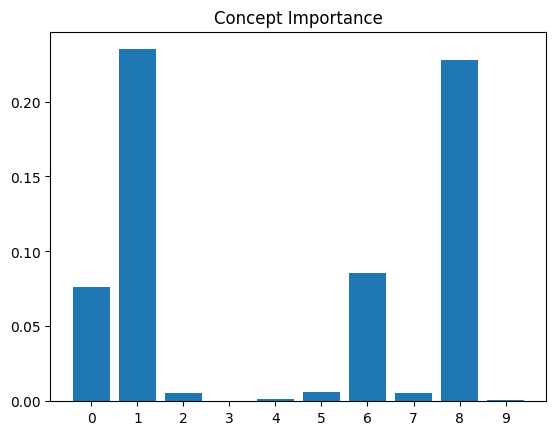

In [32]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")


most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 1  has an importance value of  0.23484759


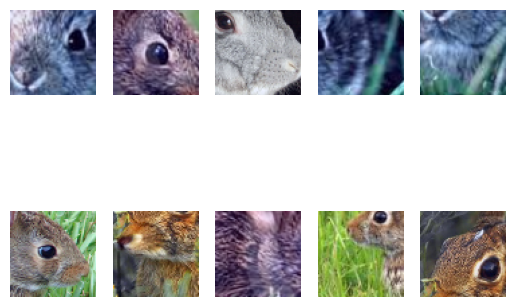




Concept 8  has an importance value of  0.22779536


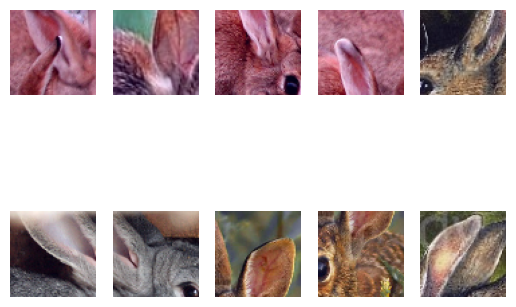




Concept 6  has an importance value of  0.08577231


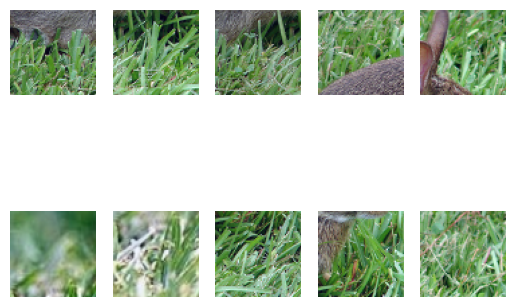




Concept 0  has an importance value of  0.07610612


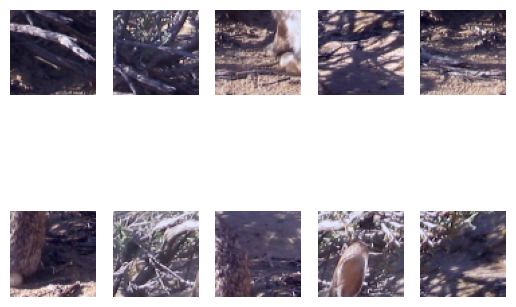




Concept 5  has an importance value of  0.0063441894


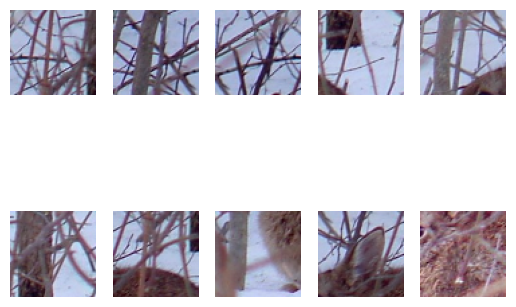

In [33]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')


for c_id in most_important_concepts:
  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [34]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

In [35]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()



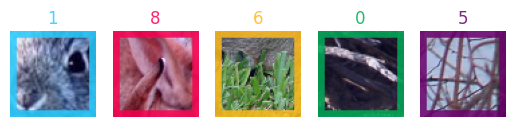

<ipython-input-33-3937862906>:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


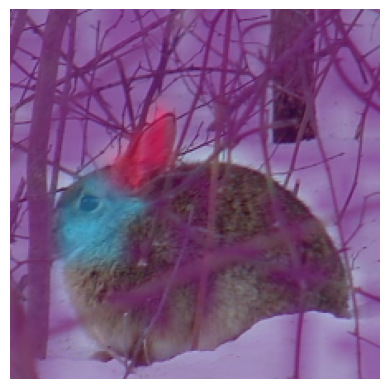

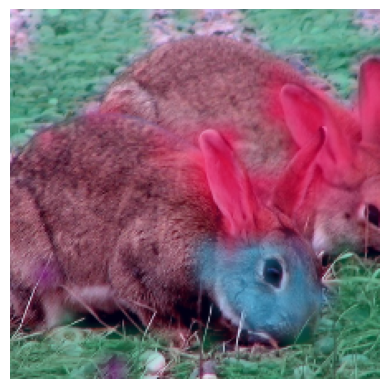

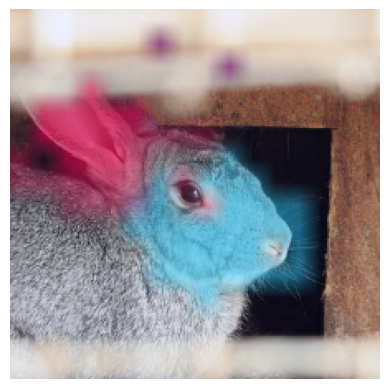

In [36]:
def concept_attribution_maps(id, percentile=90):
  img = images_preprocessed[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (224, 224))
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(9)
plt.show()